# What's in a Headline? Sentiment and Bias in Online Headlines


## Summary
The importance of understanding bias in media cannot be overstated. The divide between political left and right has grown in recent years, due at least in part to the consumption of partisan media fed to users via their social media algorithms. Furthermore, around 75% of news articles shared are passed on [based on their headlines alone](https://www.nature.com/articles/s41562-024-02067-4), without the user ever having read the linked information. As such, this project explores the relationship between bias, reliability, and tone in the headlines of popular media outlets. Using data sources from [NewsAPI](https://newsapi.org/), and bias
and reliability ratings from the [Ad Fontes Media Bias Chart](https://app.adfontesmedia.com/chart/interactive?utm_source=adfontesmedia&utm_medium=website), the goal is to analyze whether headline sentiment tends to correlate with political bias or reliability of media sources.

## Data Sourcing
### NewsAPI
All headlines and accompanying source data came from [NewsAPI](https://newsapi.org/), an HTTP REST API that can be used to search for and retrieve articles from more than 100 news sources from all over the internet.  

### Ad Fontes
Bias scores used in the analysis have been taken from Ad Fontes Media Bias Chart. [Ad Fontes](https://adfontesmedia.com/?utm_source=WEBAPP) is a public benefit corporation based in Colorado whose stated aim is to ["rate all the news to positively transform society"](https://adfontesmedia.com/about-ad-fontes-media/). Using analysts with political views spanning the entirety of the political spectrum, Ad Fontes assigns to each article or outlet a rating for both *bias* and *reliability*. 

Politically neutral sources have a bias score close to 0, while those skewing left and right have negative and positive scores respectively, with the strength of the score correlating to the degree of bias (i.e. the higher the absolute value of the score, the more biased the source is). 

Reliability is rated on scale of 0 to 64 with the highest scores being given to outlets with fact-based reporting and a high degree of effort applied towards neutrality. Toward the middle of the spectrum, media sources have less reliability in their reporting or are a mixture of fact and opinion based articles. And, finally, those sources at the bottom of the scale contain information that is misleading, inaccurate, or fabricated.


## Data Collection
The following outlines the specific functionality of each Python script and the steps taken to arrive at the dataset used in the analysis (`flattened_articles.csv`). Although it was necessary to compile the list of Ad Fontes sources manually, each file following step 2 could be combined into a single script. For the sake of clarity, as well as modularity/reusability, they have been left as separate steps.

1. `fetch_newsapi_sources.py` - Retrieves the full list of news sources from NewsAPI, and saves
them in JSON format to `data/raw/newsapi_sources.json`.
2. `ad_fontes_sources.json` - A JSON-formatted list of news sources with their associated 
bias and reliability scores from Ad Fontes. As Ad Fontes only provides data for their paid tiers, it was necessary to compile this manually based on overlapping sources from NewsAPI.
3. `merge_sources.py` - Merges the sources from NewsAPI with their bias and reliability scores from Ad Fontes and saves them in JSON format to `data/raw/merged_sources.json`
4. `fetch_hl_objects_from_api.py` - Fetches the headline/article objects from NewsAPI and saves them in JSON format to `data/raw/headline_objects.json`. This script can be exceuted multiple times, as the new data is integrated with the existing data, and duplicates are overwritten. All data for this analysis was collected between 10/4/2025 and 10/9/2025 using a cron job set to fetch articles every hour.
5. `flatten_articles.py` - Flattens all article objects into a csv file saved to `data/flattened_articles.csv`.

## Data Preparation

In [36]:
# Necessary imports
import json
import pandas as pd 
import numpy as np 
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib import pyplot as plt
import seaborn as sns
# The following line must run the first time notebook is executed to download the 
# VADER dictionary, but can be skipped in subsequent executions
# nltk.download('vader_lexicon')

In [37]:
# import sources into a dataframe to obtain bias/reliability data
with open ("../data/raw/merged_sources.json", "r") as file:
    sources = json.load(file)
sources_df = pd.DataFrame.from_dict(sources, orient="index")
sources_df.head(3)
    

,id,name,description,url,category,country,reliability,bias
abc news,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.60,-3.10
al jazeera english,al-jazeera-english,al jazeera english,"news, analysis from the middle east and worldw...",https://www.aljazeera.com,general,us,41.28,-7.31
associated press,associated-press,associated press,the ap delivers in-depth coverage on the inter...,https://apnews.com/,general,us,44.81,-2.47


In [38]:
# import the article information into a Pandas dataframe
article_df = pd.read_csv("../data/flattened_articles.csv")
article_df.head(3)

,id,name,author,title,description,url,urlToImage,publishedAt,content
0,cbs-news,CBS News,Matt Richardson,"Here's how much a $30,000 HELOC costs monthly ...","A $30,000 HELOC is inexpensive after the Fed c...",https://www.cbsnews.com/news/how-much-a-30000-...,https://assets1.cbsnewsstatic.com/hub/i/r/2015...,2025-10-03T14:13:09Z,HELOC borrowing costs are declining again now ...
1,fox-news,Fox News,NaN,Diddy sentencing begins as rapper faces up to ...,"The disgraced music mogul Sean ""Diddy"" Combs f...",https://www.foxnews.com/entertainment/diddy-se...,https://static.foxnews.com/foxnews.com/content...,2025-10-03T14:12:57Z,"Sean ""Diddy"" Combs appeared in court Friday, m..."
2,cbs-news,CBS News,CBS News,Vengeful veterinarian eyed in Oregon man's par...,Investigators discover a trail of evidence aft...,https://www.cbsnews.com/video/vengeful-veterin...,https://assets2.cbsnewsstatic.com/hub/i/r/2025...,2025-10-03T14:11:00Z,Copyright ©2025 CBS Interactive Inc. All right...


In [39]:
# merge dataframes
df = pd.merge(sources_df, article_df, on="id")
df.head(3)

,id,name_x,description_x,url_x,category,country,reliability,bias,name_y,author,title,description_y,url_y,urlToImage,publishedAt,content
0,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.6,-3.1,ABC News,ROB GILLIES Associated Press,Canadian Prime Minister Mark Carney to meet Tr...,Canadian Prime Minister Mark Carney is to hold...,https://abcnews.go.com/International/wireStory...,https://i.abcnewsfe.com/a/6d778f67-3556-4a35-9...,2025-10-03T13:58:26Z,TORONTO -- TORONTO (AP) Canadian Prime Ministe...
1,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.6,-3.1,ABC News,LINDSAY WHITEHURST Associated Press,Supreme Court to consider overturning Hawaii l...,The Supreme Court says it will consider overtu...,https://abcnews.go.com/US/wireStory/supreme-co...,https://i.abcnewsfe.com/a/bad5c649-e480-4f7d-b...,2025-10-03T13:53:11Z,WASHINGTON -- WASHINGTON (AP) The Supreme Cour...
2,abc-news,abc news,"your trusted source for breaking news, analysi...",https://abcnews.go.com,general,us,44.6,-3.1,ABC News,The Associated Press,Early snowfall damages power lines and snarls ...,Early snowfall in the Western Balkans has left...,https://abcnews.go.com/International/wireStory...,https://i.abcnewsfe.com/a/216854b3-335e-46d4-a...,2025-10-03T13:32:47Z,"BELGRADE, Serbia -- BELGRADE, Serbia (AP) Earl..."


In the cell below, unnecessary columns are dropped. Note that the 'title' column contains the headlines that are used for sentiment analysis.

In [40]:
# remove unnecessary columns
df = df[["id", "name_x", "category", "reliability", "bias", "author", "title"]]
# add a new column for the strenght of the bias, regardless of direction
df["bias_strength"] = df["bias"].abs()
df.head(3)

,id,name_x,category,reliability,bias,author,title,bias_strength
0,abc-news,abc news,general,44.6,-3.1,ROB GILLIES Associated Press,Canadian Prime Minister Mark Carney to meet Tr...,3.1
1,abc-news,abc news,general,44.6,-3.1,LINDSAY WHITEHURST Associated Press,Supreme Court to consider overturning Hawaii l...,3.1
2,abc-news,abc news,general,44.6,-3.1,The Associated Press,Early snowfall damages power lines and snarls ...,3.1


## General Source Statistics
Before diving into the sentiment analysis, we will look at the sources themselves to determine where the data come from and what impact it might have on the analysis

In [41]:
# source information 
source_ids = df["id"].unique()
left_sources = df[df["bias"] < 0]["id"].unique()
right_sources = df[df["bias"] > 0]["id"].unique()
left_headlines = df[df["id"].isin(left_sources)]
right_headlines = df[df["id"].isin(right_sources)]
avg_left_hl_length = left_headlines["title"].str.len().mean()
avg_right_hl_length = right_headlines["title"].str.len().mean()

print(f"Number of unique sources: {len(source_ids)}")
print(f"Number of left-skewing sources: {len(left_sources)}")
print(f"Number of right_skewing sources: {len(right_sources)}")
print(f"\nNumber of headlines per source:")
id_group = df.groupby("id")
print(id_group["id"].count())
print(f"Number of headlines from left-skewing sources: {len(left_headlines)}")
print(f"Number of headlines from right-skewing sources: {len(right_headlines)}")
print(f"\nTotal number of headlines: {len(df)}")


Number of unique sources: 19
Number of left-skewing sources: 16
Number of right_skewing sources: 3

Number of headlines per source:
id
abc-news                     310
al-jazeera-english           173
associated-press              55
bbc-news                     178
bloomberg                     18
breitbart-news               219
business-insider             216
cbs-news                     361
cnn                           66
fox-news                     372
msnbc                         51
nbc-news                     100
newsweek                       2
politico                       2
the-american-conservative      7
the-hill                       8
the-washington-post            5
time                           2
usa-today                    214
Name: id, dtype: int64
Number of headlines from left-skewing sources: 1761
Number of headlines from right-skewing sources: 598

Total number of headlines: 2359


Text(0.5, 1.0, 'Number of Sources by Bias')

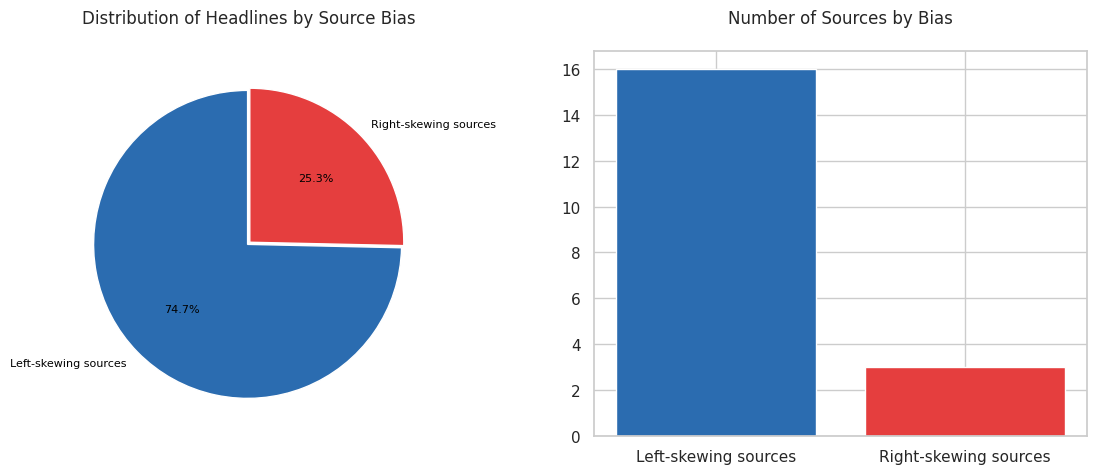

In [68]:
colors = ["#2b6cb0", "#e53e3e"]
labels = ["Left-skewing sources", "Right-skewing sources"]
explode = (0.01, 0.01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,5))

# Headlines by source bias pie chart
ax1.pie(
    [len(left_headlines), len(right_headlines)], 
    colors = colors,
    autopct='%1.1f%%',
    labels=labels,
    explode=explode,
    startangle=90,
    textprops={"fontsize": 8, "color":"black"})
ax1.set_title('Distribution of Headlines by Source Bias', fontsize=12, pad=20)

# Number of sources by bias
ax2.bar(labels, [len(left_sources), len(right_sources)], color=colors)
ax2.set_title("Number of Sources by Bias", fontsize=12, pad=20)


Text(0, 0.5, 'Number of Sources')

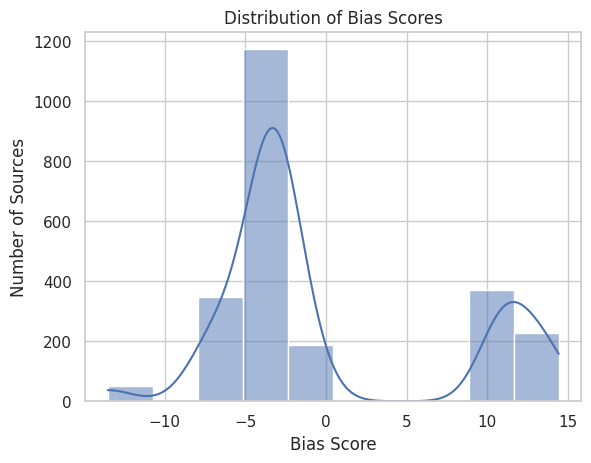

In [66]:
sns.histplot(df["bias"], kde=True, bins=10)
plt.title("Distribution of Bias Scores")
plt.xlabel("Bias Score")
plt.ylabel("Number of Sources")

Looking at the pie and bar charts above, the source distribution is clearly less than ideal, heavily favoring left-leaning sources. The histogram offers a bit more clarity, showing that most of the sources have a center-left bias, with a few others further left and a small cluster of outlets to the right. Note, however, that Ad Fontes assigns heavily skewed sources bias scores in the twenties and even thirties (positive or negative, with the greatest absolute value bias as 31.67), so all sources used are fairly moderate in their leanings.

Despite the skewed distribution, with 598 headlines drawn from right-leaning sources, there is a large enough sample size for a meaningful analysis, but this disparity will be important to keep in mind for any comparisons between the two sides.

## Sentiment Analysis

Understanding the tone of a headline is the core of this study, as headlines are the primary vehicle through which readers form their first impression of a story. To analyze the emotional polarity of each headline, this project uses [VADER (Valence Aware Dictionary and sEntiment Reasoner)](https://www.nltk.org/_modules/nltk/sentiment/vader.html), a lexicon and rule-based sentiment analysis tool included with the NLTK library.

Unlike machine-learning models that require large, labeled training datasets, VADER comes pre-tuned and is particularly effective for short, informal text such as social media posts and news headlines. It was developed to capture the intensity and context of language by accounting for factors such as capitalization (“GREAT” vs. “great”), punctuation (“!!!”), degree modifiers (“very good”), and negations (“not bad”).

For each headline, VADER assigns four metrics:
- pos - the proportion of words with positive valence
- neu - the proportion of words with neutral valence
- neg - the proportion of words with negative valence
- compound - a normalized score between -1 (most negative) and +1 (most postiive)

The compound score provides a concise overall measure of sentiment and will be the primary variable used in this analysis. Following established conventions,

- values ≥ 0.05 are classified as positive,
- values ≤ -0.05 as negative, and
- values between -0.05 and 0.05 as neutral.

VADER’s design makes it particularly appropriate for this dataset, as headlines are short, emotionally charged, and often crafted to evoke reactions. This allows us to explore whether the sentiment of headlines differs systematically across outlets with varying levels of bias and reliability.

In [44]:
# a reminder of what the dataframe looks like. Analysis will be ran on the 'title' column
df.head(2)

,id,name_x,category,reliability,bias,author,title,bias_strength
0,abc-news,abc news,general,44.6,-3.1,ROB GILLIES Associated Press,Canadian Prime Minister Mark Carney to meet Tr...,3.1
1,abc-news,abc news,general,44.6,-3.1,LINDSAY WHITEHURST Associated Press,Supreme Court to consider overturning Hawaii l...,3.1


In [45]:
# initialize analyzer and apply to each headline, adding a new column for the compound score to the dataframe
analyzer = SentimentIntensityAnalyzer()
df["sentiment_score"] = df["title"].apply(lambda x: analyzer.polarity_scores(x)["compound"])


In [46]:
# the dataframe with the new sentiment_score and
df.head(2)

,id,name_x,category,reliability,bias,author,title,bias_strength,sentiment_score
0,abc-news,abc news,general,44.6,-3.1,ROB GILLIES Associated Press,Canadian Prime Minister Mark Carney to meet Tr...,3.1,0.0000
1,abc-news,abc news,general,44.6,-3.1,LINDSAY WHITEHURST Associated Press,Supreme Court to consider overturning Hawaii l...,3.1,0.5574


## Initial Sentiment statistics
With the sentiment score (specifically the normalized compound score) added to the dataframe, we can look at some initial statistics to get a sense of the overall tone of the headlines in the dataset.

In [ ]:
# summary statistics for the sentiment scores
print(df["sentiment_score"].describe())

# get the number of headlines with each valence and the coefficient of variation
negative_sentiment = df[df["sentiment_score"] <= -0.05]
neutral_sentiment = df[(df["sentiment_score"] > -0.05) & (df["sentiment_score"] < 0.05)]
positive_sentiment = df[df["sentiment_score"] >= 0.05]
cv = df["sentiment_score"].std() / df["sentiment_score"].mean()

print("\n")
print(f"Number of headlines with negative sentiment: {len(negative_sentiment)}")
print(f"Number of headlines with neutral sentiment: {len(neutral_sentiment)}")
print(f"Number of headlines with positive sentiment: {len(positive_sentiment)}")

count    2359.000000
mean       -0.061251
std         0.408131
min        -0.936000
25%        -0.361200
50%         0.000000
75%         0.153100
max         0.942300
Name: sentiment_score, dtype: float64


Number of headlines with negative sentiment: 916
Number of headlines with neutral sentiment: 780
Number of headlines with positive sentiment: 663


Text(0, 0.5, 'Count')

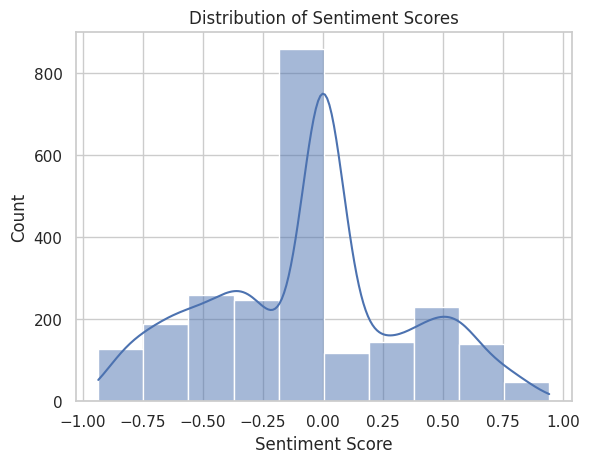

In [76]:
sns.histplot(df["sentiment_score"], kde=True, bins=10)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Count")

The mean sentiment of a headline is slightly negative at around -0.06, with a median score of 0 and a standard deviation of 0.4.

33% of headlines are neutral, 39% are negative, and 28% are postive.

## Sentiment vs Bias

In [79]:
df[["sentiment_score", "bias", "bias_strength"]].corr("pearson")

,sentiment_score,bias,bias_strength
sentiment_score,1.000000,-0.068562,-0.103233
bias,-0.068562,1.000000,0.699143
bias_strength,-0.103233,0.699143,1.000000


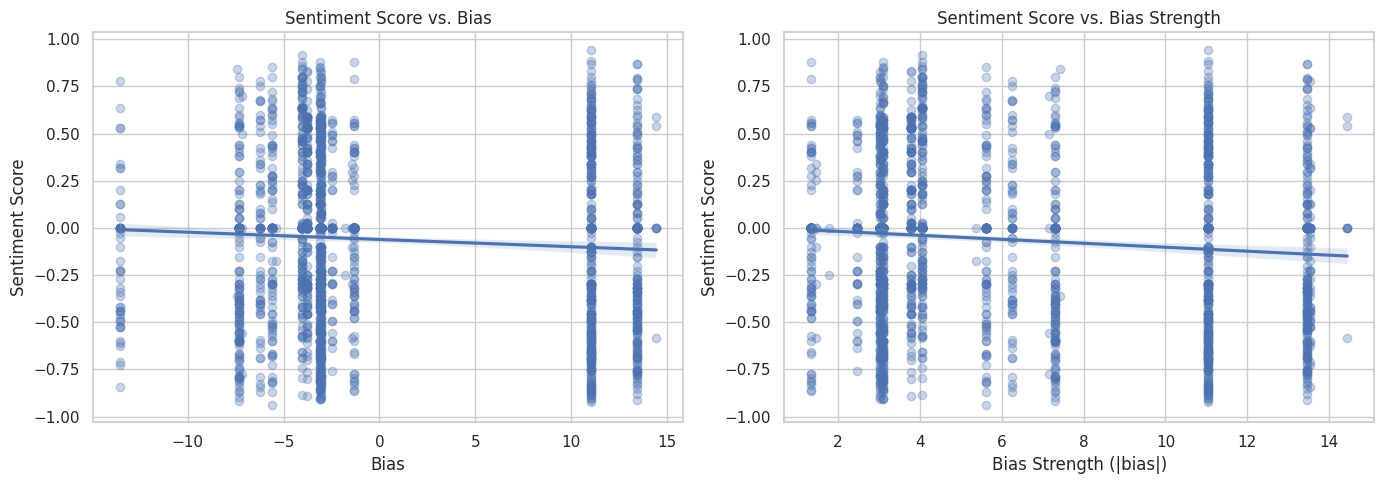

In [80]:
# Create side-by-side subplots (1 row, 2 columns)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Scatterplot of sentiment vs bias
sns.regplot(data=df, x="bias", y="sentiment_score", 
            scatter_kws={"alpha": 0.3}, ax=ax1)
ax1.set_title("Sentiment Score vs. Bias")
ax1.set_xlabel("Bias")
ax1.set_ylabel("Sentiment Score")

# Right: Scatter plot of sentiment vs bias strength
sns.regplot(data=df, x="bias_strength", y="sentiment_score", 
            scatter_kws={"alpha": 0.3}, ax=ax2)
ax2.set_title("Sentiment Score vs. Bias Strength")
ax2.set_xlabel("Bias Strength (|bias|)")
ax2.set_ylabel("Sentiment Score")

plt.tight_layout()
plt.show()


Additionally, we can see that there is little correlation between sentiment and bias or between sentiment and bias strength, with *r* = -0.068562 and *r* = -0.103233, respectively.
